In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('../data/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:21, 1425.71it/s]


#  Домашнее задание по NLP # 2 [100 баллов] 
## Составление словарей для классификации по тональности
При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.  

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).


Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

In [4]:
responses[99]

{'author': 'ronnichka',
 'bank_license': 'лицензия № 880',
 'bank_name': 'Югра',
 'city': 'г. Саратов',
 'datetime': '2015-06-03 20:56:57',
 'num_comments': 0,
 'rating_grade': 3,
 'rating_not_checked': False,
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'title': 'Карта ко вкладу'}

## Часть 1. Обучение модели word2vec [50 баллов]

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова. 
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    * тест на определение ближайших слов
    * тест на аналогии (мужчина – король : женщина – королева)
    * тест на определение лишнего слова.
    
4. Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.  Более формально:
    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  
 


Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

Превый пункт уже делался, поэтому загружу файлик :)

In [5]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

from nltk import FreqDist

from sklearn.manifold import TSNE

In [6]:
lem_text = pd.Series.from_csv('../5.3/lem.csv')

/home/anton/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [7]:
lem_text.head()

0    добрый день являться клиент банк поручитель кр...
1    добрый день являться держатель зарплатной карт...
2    здравствовать дублировать свой заявление можай...
3    добрый день открывать расчетный счет сбербанк ...
4    г взять кредит ваш банк заявлять я сумма рубль...
dtype: object

In [8]:
texts = [str(text).split() for text in lem_text.values]

In [9]:
%%time
model = Word2Vec(texts, size=100, window=5, min_count=5, workers=4)
model.save("w2v.model")

CPU times: user 7min 48s, sys: 1.52 s, total: 7min 49s
Wall time: 2min 12s


In [10]:
len(model.wv.vocab)

31905

In [11]:
%%time
texts_big = Phraser(Phrases(texts))[texts]

CPU times: user 2min 39s, sys: 390 ms, total: 2min 40s
Wall time: 2min 40s


In [12]:
%%time
model_big = Word2Vec(texts_big, size=100, window=5, min_count=5, workers=4)
model_big.save("w2v_big.model")

CPU times: user 17min 56s, sys: 3.16 s, total: 17min 59s
Wall time: 13min 42s


In [13]:
len(model_big.wv.vocab)

58641

In [14]:
def print_(word):
    print('UNI : {},\n\nBIG : {}'.format(model.wv.most_similar(word), model_big.wv.most_similar(word)))

In [15]:
print_("сбербанк")

UNI : [('сб', 0.7433988451957703), ('сбер', 0.6545405983924866), ('мкб', 0.5828083753585815), ('ситибанк', 0.5534544587135315), ('сбрф', 0.5202193260192871), ('сбера', 0.5140935182571411), ('банк', 0.5119701027870178), ('сбербанковский', 0.4844156503677368), ('промсвязьбанк', 0.4787391126155853), ('втб', 0.47248807549476624)],

BIG : [('сбер', 0.7166040539741516), ('сб', 0.7053060531616211), ('сб_рф', 0.6966725587844849), ('сбербанк_россия', 0.6782997250556946), ('сбера', 0.6086636781692505), ('втб', 0.545473575592041), ('сбрф', 0.5195678472518921), ('банк', 0.5101021528244019), ('райффайзенбанк', 0.4927844703197479), ('росбанк', 0.48522740602493286)]


In [16]:
print_('райффайзенбанк')

UNI : [('москомприватбанк', 0.7616785764694214), ('юникредитбанк', 0.74193274974823), ('втб', 0.7290306687355042), ('бинбанк', 0.7236742973327637), ('росбанк', 0.6949949264526367), ('транскредитбанк', 0.6917705535888672), ('ситибанк', 0.6884472966194153), ('промсвязьбанк', 0.6862752437591553), ('райфайзенбанк', 0.6806675791740417), ('юникредит', 0.675665020942688)],

BIG : [('ситибанк', 0.7850058674812317), ('втб', 0.7483325600624084), ('псб', 0.7422342896461487), ('росбанк', 0.7370394468307495), ('промсвязьбанк', 0.7212141156196594), ('бинбанк', 0.7143594026565552), ('райфа', 0.7116634845733643), ('юникредитбанк', 0.7068464159965515), ('юникредит', 0.6791782379150391), ('райффайзен', 0.6766066551208496)]


In [17]:
model.wv.most_similar(positive=["женщина","королева"], negative=["мужчина"])

[('щелково', 0.7960656881332397),
 ('одинцово', 0.7946217656135559),
 ('чехов', 0.7874495387077332),
 ('балашиха', 0.7838912606239319),
 ('ломоносов', 0.7819476127624512),
 ('серпухов', 0.7806255221366882),
 ('лермонтов', 0.7784616947174072),
 ('солнечногорск', 0.7767361998558044),
 ('красноармейский', 0.7765939235687256),
 ('академик', 0.7754013538360596)]

In [18]:
model_big.wv.most_similar(positive=["женщина","королева"], negative=["мужчина"])

[('н_новгород', 0.7930011749267578),
 ('пушкин', 0.7897937297821045),
 ('космонавт', 0.7773779034614563),
 ('владимирский', 0.7747085690498352),
 ('энгельс', 0.7741522789001465),
 ('г_иваново', 0.7737590074539185),
 ('чехов', 0.7716212868690491),
 ('г_рязань', 0.768304705619812),
 ('ореховый_зуево', 0.7649009823799133),
 ('гагарин', 0.7595731616020203)]

В данном корпусе королева это город Каралев.

In [19]:
model.wv.most_similar(positive=["мужчина","король"], negative=["женщина"])

[('репка', 0.725068211555481),
 ('ель', 0.7052034139633179),
 ('яблоня', 0.7035322189331055),
 ('стрельнуть', 0.701299786567688),
 ('плитка', 0.6981036067008972),
 ('унитаз', 0.6967124938964844),
 ('поп', 0.6965233683586121),
 ('стрелять', 0.6962116956710815),
 ('дружище', 0.6953310966491699),
 ('холодок', 0.6931686997413635)]

In [20]:
model_big.wv.most_similar(positive=["мужчина","король"], negative=["женщина"])

[('пуховик', 0.7671568393707275),
 ('макияж', 0.7668764591217041),
 ('плитка', 0.7533177733421326),
 ('локоть', 0.7487969398498535),
 ('вонь', 0.7475057244300842),
 ('обезьяна', 0.7474068999290466),
 ('гроб', 0.7463114857673645),
 ('коричневый', 0.7462420463562012),
 ('слон', 0.7388272285461426),
 ('ковыряться_нос', 0.7368519306182861)]

In [21]:
model.wv.doesnt_match("кредит счет машина ссуда".split())

'счет'

In [22]:
model.wv.doesnt_match("втб юникредитбанк ситибанк кость москомприватбанк бинбанк юникредит промсвязьбанк".split())

'кость'

In [23]:
top_words = []
fd = FreqDist()
for text in texts:
    fd.update(text)
for i in fd.most_common(200):
    top_words.append(i[0])
print(top_words)

['банк', 'карта', 'деньги', 'день', 'мой', 'кредит', 'который', 'отделение', 'клиент', 'сотрудник', 'счет', 'сказать', 'сумма', 'получать', 'заявление', 'год', 'свой', 'вопрос', 'время', 'мочь', 'такой', 'кредитный', 'приходить', 'ответ', 'вклад', 'офис', 'данный', 'телефон', 'платеж', 'договор', 'ваш', 'номер', 'звонить', 'банкомат', 'сбербанк', 'очень', 'позвонить', 'г', 'месяц', 'написать', 'проблема', 'обращаться', 'другой', 'решать', 'работать', 'какой', 'средство', 'рубль', 'работа', 'документ', 'ситуация', 'звонок', 'отвечать', 'говорить', 'один', 'человек', 'хотеть', 'операция', 'почему', 'давать', 'информация', 'сообщать', 'сделать', 'смс', 'оформлять', 'срок', 'услуга', 'быть', 'просто', 'знать', 'должный', 'заявка', 'банка', 'обслуживание', 'очередь', 'минута', 'сегодня', 'девушка', 'первый', 'ждать', 'сайт', 'руб', 'претензия', 'просить', 'новый', 'интернет', 'процент', 'принимать', 'снимать', 'тот', 'выдавать', 'неделя', 'этот', 'открывать', 'никакой', 'оператор', 'являтьс

In [24]:
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(model[top_words])

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [25]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

Видны кластеры:
    1. про время
    2. про суммы и денежные опирации
    3. обращения через средства связи
    4. обращения письменныез
    5. действия клиентов

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(model[top_words])

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


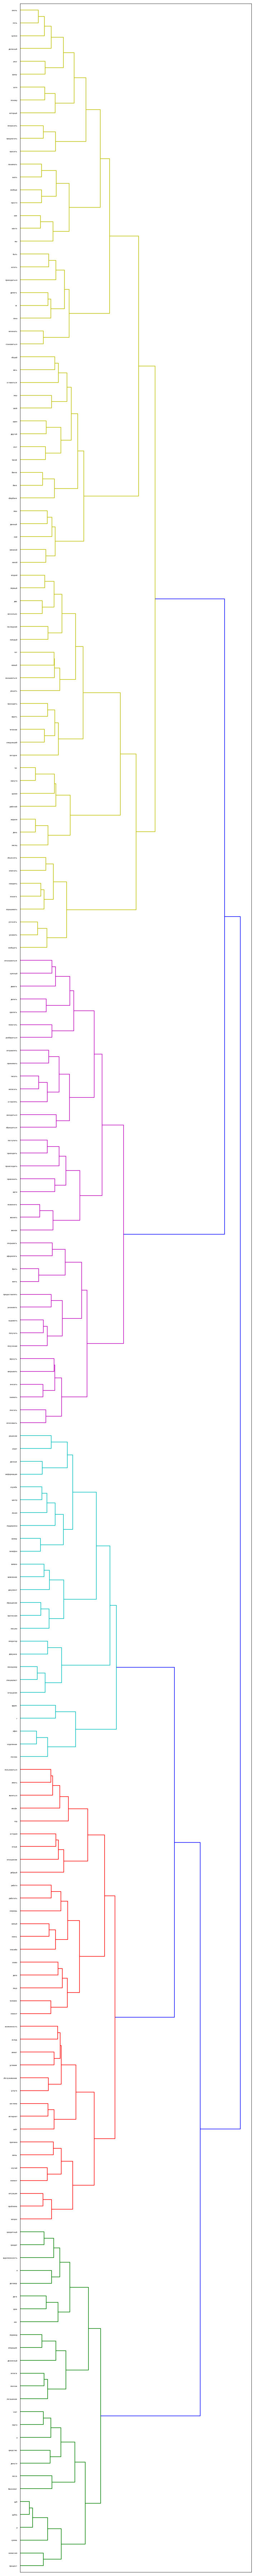

In [27]:
from scipy.cluster.hierarchy import  ward, dendrogram

linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(10, 100)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=top_words);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() 

plt.savefig('w2v_clusters.png', dpi=200) #save figure as ward_clusters

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


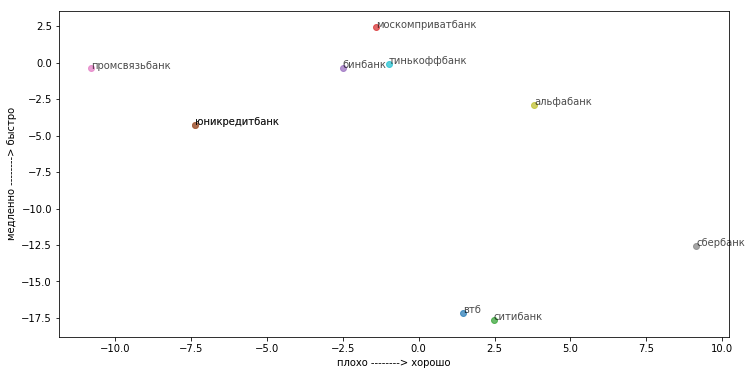

In [28]:
x2, x1 = ['плохо', 'хорошо']
y2, y1 = ['медленно', 'быстро']
x_label = "%s --------> %s" % (x2, x1)
y_label = "%s --------> %s" % (y2, y1)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
banks = "втб юникредитбанк ситибанк москомприватбанк бинбанк юникредитбанк промсвязьбанк сбербанк альфабанк тинькоффбанк".split()
for bank in banks:
    x = model[bank].dot(model[x2] - model[x1])
    y = model[bank].dot(model[y2] - model[y1])
    ax.scatter(x, y, alpha=0.7)
    ax.text(x, y, bank, alpha=0.7)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.show()

люди считают что сбербанк это не плохо)

## Часть 2. Распространение метки [50 баллов]

Определите 5-8 позитивных слов (например, “быстрый”, “удобный”) и 5-8  негативных слов (например,“очередь”, “медленно”). Эти слова будут основной будущего оценочного словаря. Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 – это и есть искомые оценочные слова.

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в выршине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:
1. ```graphlab.label_propagation``` (```graphlab``` доступен бесплатно по образовательной лицензии)
2. ```sklearn.semi_supervised.LabelPropagation``` 
3. ```sklearn.semi_supervised.LabelSpreading```

In [162]:
from sklearn.semi_supervised import LabelSpreading

In [185]:
all_words = list(set(model.wv.vocab.keys()))

In [177]:
words_pos = ['быстрый', 'удобный', 'хорошо']
words_neg = ['очередь', 'медленно', 'сложно']

label_w = words_pos + words_neg

voc = [w for w in all_words if w not in label_w]

words_t = np.array(label_w + all_words)

In [178]:
x = model.wv[words_t]
# (unlabeled points are marked as -1) 
label_y = np.array([0]*3 + [1]*3 + [-1]*len(all_words))

In [179]:
label_y[:20]

array([ 0,  0,  0,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

In [180]:
words_t[:20]

array(['быстрый', 'удобный', 'хорошо', 'очередь', 'медленно', 'сложно',
       'иначе', 'помолчать', 'восьмилетний', 'подслеповатый',
       'передоверие', 'каникулы', 'наверняка', 'эка', 'недоказуемый',
       'перезагрузка', 'рисование', 'онлайм', 'загородка',
       'последователь'], dtype='<U26')

In [181]:
%%time
propagation_model = LabelSpreading(n_jobs=4)
propagation_model.fit(x, label_y)

/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


CPU times: user 1min 11s, sys: 1min, total: 2min 12s
Wall time: 7min 25s


In [182]:
predicted_labels = propagation_model.predict(model[model.wv.vocab])

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [184]:
1 in predicted_labels

False

не понятно почему у меня один клас в итоге получается. И зачем тут пример построения графа

In [187]:
# пример построения графа 

import igraph as ig
g = ig.Graph(directed=True)
for word in model.wv.vocab.keys():
    g.add_vertex(word)
    
for word in model.wv.vocab.keys() :
    node = g.vs.select(name = word).indices[0]
    similar_words = model.most_similar(word, topn=5)
    for sim in similar_words:
        word1 = sim[0]
        val  = sim[1]
        new_node = g.vs.select(name = word1).indices[0]
        g.add_edge(node, new_node, weight = val)

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.


KeyboardInterrupt: 

In [ ]:
plt.plot(g)